In [13]:
pip install bioservices pandas networkx matplotlib python-louvain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.3/145.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.2/750.2 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 20.6 MB/s eta 0:00:00


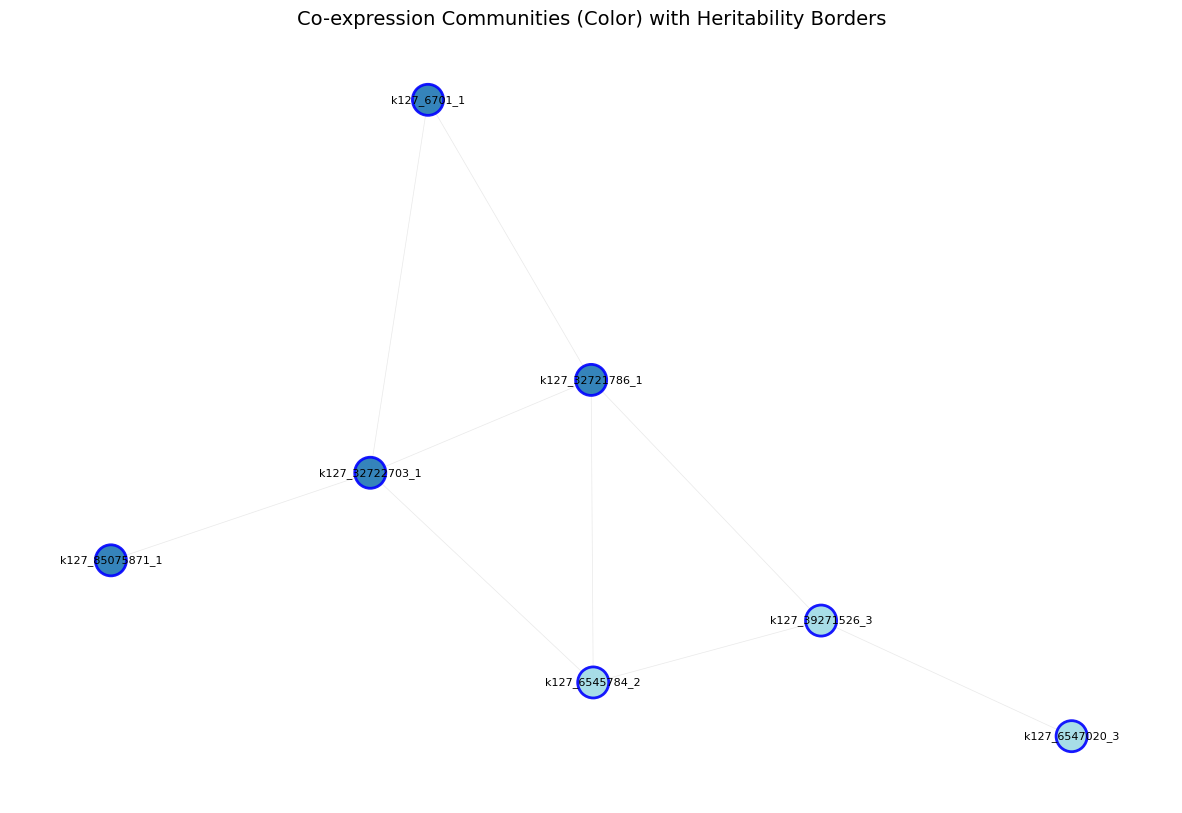

In [15]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain

# Load heritability datasets
conditions = {
    'All_Heritable': 'ORF_Matrix_All_Heritable.xlsx',
    'No_High': 'ORF_matrix_no_high_heritable.xlsx',
    'No_Moderate': 'ORF_matrix_no_moderate_heritable.xlsx',
    'No_Moderate_or_High': 'ORF_matrix_no_moderate_or_high_heritable.xlsx'
}

# Track genes in each condition
gene_conditions = {}
for cond, file in conditions.items():
    df = pd.read_excel(file, index_col='AnimalID')
    genes = df.columns.tolist()
    for gene in genes:
        if gene not in gene_conditions:
            gene_conditions[gene] = []
        gene_conditions[gene].append(cond)

# Build co-expression network (edges = high correlation)
combined_G = nx.Graph()
for cond, file in conditions.items():
    df = pd.read_excel(file, index_col='AnimalID')
    corr_matrix = df.corr().abs()
    edges = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i < j and corr_matrix.loc[i, j] > 0.5]
    combined_G.add_edges_from(edges)

# Assign node colors based on heritability priority
color_map = {
    'All_Heritable': 'blue',
    'No_High': 'green',
    'No_Moderate': 'red',
    'No_Moderate_or_High': 'purple'
}

node_colors = []
for gene in combined_G.nodes():
    if 'All_Heritable' in gene_conditions.get(gene, []):
        node_colors.append(color_map['All_Heritable'])
    elif 'No_High' in gene_conditions.get(gene, []):
        node_colors.append(color_map['No_High'])
    elif 'No_Moderate' in gene_conditions.get(gene, []):
        node_colors.append(color_map['No_Moderate'])
    elif 'No_Moderate_or_High' in gene_conditions.get(gene, []):
        node_colors.append(color_map['No_Moderate_or_High'])
    else:
        node_colors.append('gray')  # Fallback

# Detect communities using Louvain
partition = community_louvain.best_partition(combined_G)

# Visualize
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(combined_G, seed=42)
nx.draw_networkx_nodes(
    combined_G,
    pos,
    node_color=[partition[node] for node in combined_G.nodes()],  # Community colors
    cmap=plt.cm.tab20,
    node_size=500,
    edgecolors=node_colors,  # Heritability as border colors
    linewidths=2,
    alpha=0.9
)
nx.draw_networkx_edges(combined_G, pos, edge_color='lightgray', width=0.5, alpha=0.5)
nx.draw_networkx_labels(combined_G, pos, font_size=8)
plt.title("Co-expression Communities (Color) with Heritability Borders", fontsize=14)
plt.axis('off')
plt.show()
